In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
# Set up paths

path_to_data = '/expanse/nfs/cw3e/cwp140/'     # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
varname = 'SR' # 'PCPT' or 'UV' or 'SR'
perc_coverage = 75 # 25, 50, or 75

In [4]:
fname = os.path.join(path_to_data, 'preprocessed/SEAK-WRF-PCPT/{0}_quantiles_{1}.nc'.format(varname, temporal_res))
ds = xr.open_dataset(fname)
# ds = ds.sel(quantile=0.95)
ds

<xarray.Dataset>
Dimensions:   (y: 250, x: 320, quantile: 3)
Coordinates:
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
  * quantile  (quantile) float64 0.0 0.75 0.95
Dimensions without coordinates: y, x
Data variables:
    SR        (quantile, y, x) float32 ...

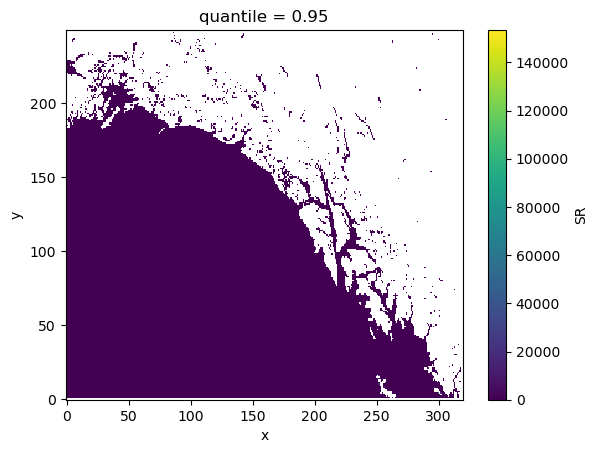

In [5]:
ds.SR.sel(quantile=0.95).plot()

In [5]:
## bounding boxes for composite analysis
bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-134.25, -132.5, 54.25, 56.75], # Craig (Southern Coastal)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

zone_lst = ['northern_coastal', 'central_coastal', 'northern_inner_channel', 'central_inner_channel', 'southern_coastal', 'southern_inner_channel']

In [6]:
if varname == 'SR':
    ## open SWE
    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format('SNOW')
    SNOW = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')

    ## open PCPT
    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format('PCPT')
    PCPT = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
    PCPT = PCPT.resample(time="1D").mean('time') # resample WRF data to be m s-1

    ### calculate percentile for fraction of rain to snow
    ## SNOW is snow water equivalent kg m^2 = mm
    ## PCPT is total precipitation in mm day-1
    ## fraction of frozen precipitation or snow ratio (SR) = SWE/PCPT
    wrf = xr.merge([SNOW, PCPT], compat="minimal")
    wrf['SR'] = wrf['SNOW'] / wrf['PCPT']
    wrf = wrf.drop_vars(['SNOW', 'PCPT'])

else:

    fname_pattern = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_*.nc'.format(varname)
    wrf = xr.open_mfdataset(fname_pattern, combine='by_coords', engine='netcdf4')
    if temporal_res == '6hr':
        wrf = wrf.resample(time="6H").sum('time') # resample WRF data to be mm per day
    elif (temporal_res == 'daily') & (varname == 'PCPT'):
        wrf = wrf.resample(time="1D").sum('time') # resample WRF data to be mm per day
        
    elif (temporal_res == 'daily') & (varname == 'UV'):
        wrf = wrf.sel(lev='1000')
        wrf = wrf.resample(time="1D").mean('time') # resample WRF data to be m s-1
wrf

<xarray.Dataset>
Dimensions:  (time: 14610, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    SR       (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Tue Dec 11 12:06:10 AKST 2018

In [7]:


## subset to AR days only
## append AR data
fname = '../out/SEAK_ardates_{0}.csv'.format(temporal_res)
ar_df = pd.read_csv(fname) # read in AR dates
idx = (ar_df.AR == 1)
ar_df = ar_df.loc[idx]
# reset the index as "time"
ar_df = ar_df.set_index(pd.to_datetime(ar_df['Unnamed: 0']))
## subset dates to Jan 2000 - Dec 2019
idx = (ar_df.index.year >= 2000) & (ar_df.index.year <= 2019)
ar_df = ar_df.loc[idx]
ar_dates = ar_df.index.values

wrf = wrf.sel(time=ar_dates)
wrf

<xarray.Dataset>
Dimensions:  (time: 2463, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-06 2000-01-08 ... 2019-08-26
    lat      (y, x) float32 53.12 53.12 53.13 53.13 ... 61.97 61.97 61.96 61.95
    lon      (y, x) float32 -148.1 -148.0 -147.9 -147.9 ... -126.4 -126.3 -126.3
Dimensions without coordinates: y, x
Data variables:
    SR       (time, y, x) float32 dask.array<chunksize=(1, 250, 320), meta=np.ndarray>
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Tue Dec 11 12:06:10 AKST 2018

In [8]:
%%time
## get the total number of grids in each subregion
total_grid_ct = []
for i, ext in enumerate(bboxes):
    idx = (wrf.lat >= ext[2]) & (wrf.lat <= ext[3]) & (wrf.lon >= ext[0]) & (wrf.lon <= ext[1])
    mask = wrf.where(idx)
    tmp = mask.isel(time=0)
    grid_ct = tmp[varname].count(['y', 'x']).compute()
    total_grid_ct.append(grid_ct.values)

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/minic

CPU times: user 7.68 s, sys: 391 ms, total: 8.07 s
Wall time: 10.5 s


/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [9]:
%%time
## subset WRF to grids that fall within the percentile categories
impact_level_lst = ['low', 'medium', 'high']
for k, impact_level in enumerate(impact_level_lst):
    if impact_level == 'high':
        ## use where statement to get dates where precip >95th percentile
        tmp = wrf.where(wrf[varname] >= ds[varname].sel(quantile=0.95))
        tmp = tmp.compute()
    elif impact_level == 'medium':
        ## use where statement to get dates where precip >75th percentile and <95th percentile
        idx = (wrf[varname] >= ds[varname].sel(quantile=0.75)) & (wrf[varname] <= ds[varname].sel(quantile=0.95))
        tmp = wrf.where(idx)
        tmp = tmp.compute()
    elif impact_level == 'low':
        ## use where statement to get dates where precip <75th percentile
        tmp = wrf.where(wrf[varname] <= ds[varname].sel(quantile=0.75))
        tmp = tmp.compute()
    
    ## now iterate through all the zones and compute the number of grids that fall within the percentile zones
    ## save as a csv
    for i, ext in enumerate(bboxes):
        ## temporarily subset to the region
        idx = (tmp.lat >= ext[2]) & (tmp.lat <= ext[3]) & (tmp.lon >= ext[0]) & (tmp.lon <= ext[1])
        mask = tmp.where(idx)
        
        ## get number of grids where prec >=95th percentile
        grid_ct = mask[varname].count(['y', 'x'])
        grid_perc = (grid_ct/total_grid_ct[i])*100
        final_dates = grid_perc.where(grid_perc >= perc_coverage, drop=True).time.values
    
        d = {'date': final_dates}
        df = pd.DataFrame(data=d)
        df.to_csv('../out/test_{3}percent_coverage/{0}_{1}_impact_{2}_dates.csv'.format(zone_lst[i], impact_level, varname, perc_coverage))

/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/miniconda3/envs/SEAK-impacts/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dnash/minic

CPU times: user 52.4 s, sys: 47.3 s, total: 1min 39s
Wall time: 8min 54s
